In [1]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
import re
import pickle
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]

In [3]:
df = pd.read_csv('data/archive/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=DATASET_COLUMNS)

# Clean Text

In [4]:
# Lets clean up the text
def remove_tag(string):
    return re.sub('<.*?>','',string)

def remove_mention(text):
    return re.sub(r'@\w+','',text)

def remove_hash(text):
    return re.sub(r'#\w+','',text)

def remove_newline(string):
    return re.sub('\n', '', string)

def remove_url(string):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)

def remove_number(text):
    return re.sub(r'[0-9]+','',text)

def remove_punc(text):
    return re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)

def text_strip(string):
    return re.sub('\s{2,}', ' ', string.strip())

def remove_thi_amp_ha_words(string):
    return re.sub(r'\bamp\b|\bthi\b|\bha\b',' ',string)

def clean_text(text):
    text = text.lower()
    text = remove_tag(text)
    text = remove_mention(text)
    text = remove_newline(text)
    text = remove_url(text)
    text = remove_number(text)
    text = remove_thi_amp_ha_words(text)
    text = text_strip(text)
    
    return text

In [5]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

# Feature Selection

In [6]:
# lets split the data to 9:1 ratio for train and test
x_train, x_test, y_train, y_test = train_test_split(
    df['text'].tolist(), df['target'].tolist(), test_size=0.1, random_state=0
)

In [7]:
# Feature extraction lets use tf-idf first
vectorize = TfidfVectorizer(ngram_range=(1, 2), max_features=500000, stop_words='english')
vectorize.fit(x_train)

print('No. of feature_words: ', len(vectorize.get_feature_names()))

No. of feature_words:  500000


In [8]:
x_train = vectorize.transform(x_train)
x_test = vectorize.transform(x_test)

In [9]:
# General purpose function evaluate model
def evaluate_model(model):
    y_pred = model.predict(x_test)

    results = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    categories = ['Negative', 'Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']

    group_percentage = [
        '{0:.2%}'.format(value) for value in cm.ravel() / cm.sum()
    ]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentage)]

    labels = np.array(labels).reshape(2, 2)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    sns.heatmap(
        cm, annot=labels, fmt='',
        xticklabels=categories, yticklabels=categories
    )

    print(results)

In [10]:
def save_model(model_path, model):
    file = open(model_path, 'wb')
    pickle.dump(model,file)
    file.close()

In [11]:
def load_model(model_path):
    file = open(model_path, 'rb')
    model = pickle.load(file)
    return model

# XGBoost

In [ ]:
xgb_model = XGBClassifier(
    max_depth=4, n_estimators=2000, 
    nthread=4, min_child_weight=6, gamma=0, 
    subsample=0.8, colsample_bytree=0.8,
)

xgb_model.fit(
    x_train, y_train, 
    eval_metric='error', eval_set=[(x_test, y_test)], 
    verbose=True
)

In [ ]:
evaluate_model(xgb_model)

In [ ]:
model_path = 'model/mlmodel/xgboost/xgboost_sentiment.pickle'
save_model(model_path, xgb_model)

# Inference

In [ ]:
# Simple inference
text = [
    'this is the time of your life',
    'you are stupid',
    'life is worth living',
    'why work at all'
]

In [ ]:
text_feature = vectorize.transform(text)

In [ ]:
preds = xgb_model_loaded.predict(text_feature)

for index, pred in enumerate(preds):
    if pred == 0:
        print('{}, sentiment: {}'.format(text[index], 'negative'))
    else:
        print('{}, sentiment: {}'.format(text[index], 'positive'))

# LightGBM

In [153]:
lgbm_model = LGBMClassifier(
    num_leaves=400, max_depth=9, 
    learning_rate=0.01, n_estimators=2000,
    feature_fraction=0.64, early_stopping_rounds=10,
    boosting_type='goss'
)

In [154]:
lgbm_model.fit(
    x_train, y_train, 
    eval_metric='error', eval_set=[(x_test, y_test)],
    verbose=True
)

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[1]	valid_0's binary_error: 0.447263	valid_0's binary_logloss: 0.692414
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.418869	valid_0's binary_logloss: 0.691616
[3]	valid_0's binary_error: 0.394663	valid_0's binary_logloss: 0.69119
[4]	valid_0's binary_error: 0.388425	valid_0's binary_logloss: 0.690447
[5]	valid_0's binary_error: 0.388369	valid_0's binary_logloss: 0.689741
[6]	valid_0's binary_error: 0.388819	valid_0's binary_logloss: 0.688965
[7]	valid_0's binary_error: 0.388756	valid_0's binary_logloss: 0.688281
[8]	valid_0's binary_error: 0.388706	valid_0's binary_logloss: 0.687567
[9]	valid_0's binary_error: 0.388569	valid_0's binary_logloss: 0.686975
[10]	valid_0's binary_error: 0.3

LGBMClassifier(boosting_type='goss', early_stopping_rounds=10,
               feature_fraction=0.64, learning_rate=0.01, max_depth=9,
               n_estimators=2000, num_leaves=400)

              precision    recall  f1-score   support

           0       0.80      0.29      0.43     79738
           4       0.57      0.93      0.71     80262

    accuracy                           0.61    160000
   macro avg       0.69      0.61      0.57    160000
weighted avg       0.69      0.61      0.57    160000



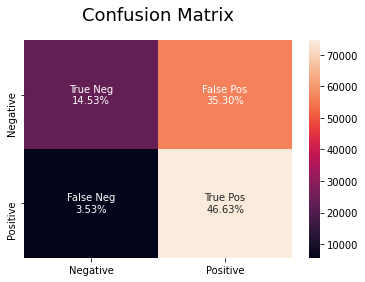

In [155]:
evaluate_model(lgbm_model)